In [1]:
import razor.flow as rf
import numpy as np
import pandas as pd

@rf.block
class CustomDataGenSession:
    out_df: rf.Output[pd.core.frame.DataFrame]
    def run(self):
        df = pd.read_csv(razor.api.project_space_path("/bank-product-recommendation/data/train.txt"),sep="|")
        df = df[['ID_Customer', 'Cod_Prod', 'Cod_Fecha']]
        df["Cod_Fecha"] =  pd.to_datetime(df["Cod_Fecha"],format='%Y-%m')
        primerMes = pd.datetime(2007, 1, 1, 0, 0, 0)
        df = df.loc[df["Cod_Fecha"]>=primerMes,]
        prod_map = pd.read_csv(razor.api.project_space_path("/cajamar_product_map.csv"))
        prod_map['Product Names'] = prod_map['Product Names'].str.strip()
        prod_map['Product Names'] = prod_map['Product Names'].str.replace('\W', '')
        df = df.merge(prod_map,on='Cod_Prod')
        for p,q in zip(prod_map['Product Names'],prod_map['Product Category']):
            if p!='DiscoveryAdmin':
                print(p+"-----------"+q)
                df.loc[(df['Product Names']!=p) & (df['Product Category']!=q),p]=np.random.choice(np.arange(1,15),((df['Product Names']!=p) & (df['Product Category']!=q)).sum())
                df.loc[df['Product Category']==q,p]=np.random.choice(np.arange(10,75),(df['Product Category']==q).sum())
                df.loc[df['Product Names']==p,p]=np.random.choice(np.arange(25,100),(df['Product Names']==p).sum())
                df[p] = df[p].astype('int')
        #roll to cust month with every customer and every month with prev month logic
        col_prods = [x for x in list(prod_map['Product Names']) if x!="DiscoveryAdmin"]
        df = df.groupby(['ID_Customer','Cod_Fecha'])[col_prods].sum().reset_index()
        df.to_csv(razor.api.project_space_path("/sess_data.csv"),index=False)
        # self.logger.info(df.head())
        # self.logger.info(df.columns)
        self.out_df.put(df)

In [2]:
@rf.block
class CustomDataGenSession4:
    out_df: rf.Output[pd.core.frame.DataFrame]
    def run(self):
        df = pd.read_csv(razor.api.project_space_path("/sess_data.csv"))
        df = pd.melt(df,id_vars=['ID_Customer','Cod_Fecha'],var_name="ProductName")
        df.to_csv(razor.api.project_space_path("/sess_data_metled.csv"),index=False)
        self.out_df.put(df)

In [8]:
cust_gen_sess = CustomDataGenSession4()
cust_gen_sess.executor =  rf.ContainerExecutor(cores=15, memory=70048)

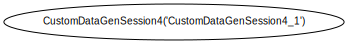

In [9]:
pipeline = rf.Pipeline(name="cust_datagen_session",targets=[cust_gen_sess])
pipeline

In [10]:
razor.api.engines('DS-Engine-Load-Test').execute(pipeline)

PlatformPipelineRun(project_id='894e2628-910c-4242-ae32-fedb5986910b', pipeline_id='3b521a9a-2a74-11eb-b7ff-0242ac110008', pipeline_name='cust_datagen_session', pipeline_run_id='f5315d8e-99f9-4b39-9c7a-10a6f193b770', pipeline_version=None, comment=None, created_on='2020-11-19T14:33:49.284+00:00', start_time=None, end_time=None, eta=0, run_at=1605796429284, run_duration=0, compute_time=0, wait_time=195, ran_by_user=RanByUser(user_name='Sidharth Behera', email='siddharth.behera@razorthink.com'), status='YET_TO_START', block_status=[PlatformPipelineBlockRun(pipeline_run_id='f5315d8e-99f9-4b39-9c7a-10a6f193b770', pipeline_name='cust_datagen_session', pipeline_status='YET_TO_START', block_id='d2435dd4-8634-4cb2-9492-4bcc614b1ed5', block_run_id='5123bf34-f3ad-40c2-986f-a562b9901c40', block_name='CustomDataGenSession4_1', resource_spec=ResourceAllocated(cores=15, memory=70048, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='d2435dd4-8634-4cb2-9492-4bcc614b1ed5', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-11-19T14:33:50.000+00:00')], run_number=3, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='d2435dd4-8634-4cb2-9492-4bcc614b1ed5', block_run_id='5123bf34-f3ad-40c2-986f-a562b9901c40', block_name='CustomDataGenSession4_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-11-19T14:33:49.489+00:00', queued_at='2020-11-19T14:33:50.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=15, memory=70048, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "3b521a9a-2a74-11eb-b7ff-0242ac110008",\n  "projectId": "894e2628-910c-4242-ae32-fedb5986910b",\n  "name": "cust_datagen_session",\n  "description": "",\n  "blocks": [\n    {\n      "name": "CustomDataGenSession4_1",\n      "id": "d2435dd4-8634-4cb2-9492-4bcc614b1ed5",\n      "artifact_id": null,\n      "class_name": "CustomDataGenSession4",\n      "code": "eJyNVV1vE0cU3V1/JogACQ2irWiFqsqoig2JIQYhJGpEBa62DVRqVZJOZ3dmM2uvd7c7s6GpHKkVCgRpaB+YPlWVQOp/4AdU6t9q78yusYV4qP3g2Tuzc+8595zrn6u/f9+0zEee8aMkJ2nojyLanlsreRZllO2TDAuK+IhGVCQx8iPMuXquWsySp9EYj962J5teHkYijLmSVbGfUgjKd/o5F8n4Fhb4Mxrfp5yHSdxVzGmxaos1WJPVZD3xhtQXcPxQHSjZQIgkPkLK5fJD3PWD3ialZN3HXby+4QVX/YvdzSueTzDxNj3lCnUP3mrJRYTGCckjCm/KJjzgMNbLEwjhOE4EFpCZQwRS1JNcIBIouYCSlALWJIO8u1SEgo512csZ/inJ2kGUPGzD2TQXAKr+hVnp/VMpjgnmbT/JaDvI8BiYW9Agb5v1c/UYquKykuWxAs6WUBBGEQry2NdVlEyemDFptiAM0eOopBFNOWz2E0K/0g+HcGtrYA+sgTOoDfr9z4X1whbOsPKiSuyX8D2whTWsTWzikMquQ6qk9qxyYE/sYb08VX9pkwZpPnNsa2INGy+aE3jLtoh131ItVy51OLQIEUDS9vmeksfu3EJFCylQtACVoNvUZxh2vsyAbl+4BnwjJGgPZ8BSE35QrIOPof2z+9CYiogSc+1TWQtjQn8EQAJa56QE3ssoJsgkrRn2lazgNIRepFmi9YF4in2KUiwYCGxMIwEtEYl5ha3Kim4NhKqcRtBZB9oLBZy7Hqb7giXxWhjDgbX1te7mpY2rF3u+d+Vq74Zi5wfVftOyl+3T9qqtLlzQcrr7L3y0po4hSOeP8K4WlatVpYHBmq3kT0rdNXajxMMR1w/sGjRwgedeOE6TTCuFXdM9Yz22JeuFZkwTc9kkNMB5BLpyZZWEIH/Q5RJYkecZBSqjnOqteqFpSCirhlR2XlbAHrB1Bs0ZF0HS4ihXO1DIllwoJKwpNCVsycVStNMQlcfmnKHzN3/IcWTSyLNvNW5bC1oujh7Oqs/FPbARirAHMtYsLSGjXOQz6o8gcqRPnJozlBcl/giUUvtUL4xZDhQ7ru3eu3yFdC97lwKfbHR76xu9S6Trk3WIBt1uD+PXdmfLbCxPImTuQqa3pbdPTYOlb02UrbL3L/xi+lUzlWpqOc1CoOuprDIapboPxnHsA7YNeloQGY65aaMrF2eIAI/H5fI0C1yyF/q0TA7DphgtqGihciFzTTZBwjBnxL5x/kct9jH7pPCxDT5e6S8LcCOxj6w/LOL8WXnkgBtd6ejx1Zje9KSYUFiIDLrHbh4q2e0w8GVnmOzt47gThR7vtMvGrJknQ3pHk94pSG+n+2AauEaAnQd/9x3LVmz7UBnZD2xN7B25OOuVYneBZ9A9zC+j+1+numcusPq1y76Bn293gGDMHrAxMPcb23HZdxAJYIfJc8WQmxLQvg51gFtutMsi2FAr6DUnjplt

In [12]:
df = pd.read_csv(razor.api.project_space_path("/sess_data_metled.csv"),nrows=20)
df

,ID_Customer,Cod_Fecha,ProductName,value
0,A0000001,2007-05-01,EverydayCheckingAccounts,85
1,A0000001,2011-04-01,EverydayCheckingAccounts,37
2,A0000001,2013-04-01,EverydayCheckingAccounts,4
3,A0000002,2015-02-01,EverydayCheckingAccounts,2
4,A0000003,2011-12-01,EverydayCheckingAccounts,8
5,A0000003,2012-05-01,EverydayCheckingAccounts,26
6,A0000003,2016-02-01,EverydayCheckingAccounts,32
7,A0000004,2008-05-01,EverydayCheckingAccounts,35
8,A0000004,2008-10-01,EverydayCheckingAccounts,22
9,A0000004,2014-12-01,EverydayCheckingAccounts,70
